# Final Project Check-in 2018-11-16

Group Name
-----

 Bean Solution

Student Names
----

1. Xin Sun
2. Zhi Li
3. Minchen Wang
4. Hongdou Li
5. Bowen Ma

# Load Data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time 
import datetime
import scipy.stats

In [4]:
data = pd.read_csv("bid.csv")
data.head()

,Unnamed: 0,bidder_id,payment_account,address,outcome,bid_id,auction,merchandise,device,time,country,ip,url
0,1,001068c415025a009fee375a12cff4fcnht8y,a3d2de7675556553a5f08e4c88d2c228iiasc,a3d2de7675556553a5f08e4c88d2c2282aj35,0,7179832.0,4ifac,jewelry,phone561,9.706350e+15,bn,139.226.147.115,vasstdc27m7nks3
1,2,0030a2dd87ad2733e0873062e4f83954mkj86,a3d2de7675556553a5f08e4c88d2c228jem8t,f3bc67b04b43c3cebd1db5ed4941874c9br67,0,6805028.0,obbny,mobile,phone313,9.704550e+15,ir,21.67.17.162,vnw40k8zzokijsv
2,3,00a0517965f18610417ee784a05f494d4dw6e,52743ba515e9c1279ac76e19f00c0b001p3pm,7578f951008bd0b64528bf81b8578d5djy0uy,0,4574244.0,gst86,books and music,phone1400,9.642090e+15,ng,160.114.155.198,utvvayoovsqfycf
3,4,00a0517965f18610417ee784a05f494d4dw6e,52743ba515e9c1279ac76e19f00c0b001p3pm,7578f951008bd0b64528bf81b8578d5djy0uy,0,7525691.0,b25ls,books and music,phone142,9.708600e+15,in,210.227.213.71,wxmtewnifm8v3kb
4,5,00a0517965f18610417ee784a05f494d4dw6e,52743ba515e9c1279ac76e19f00c0b001p3pm,7578f951008bd0b64528bf81b8578d5djy0uy,0,6511001.0,1cbiu,books and music,phone25,9.702980e+15,in,86.245.94.173,q7mzsnjxikn3tq3


### Data Clean

In [5]:
# for all the missing value observation, drop it
bid = data.dropna()

### Feature Creation

In [6]:
# bidding time difference per user (bidder_id) (done)
bid = bid.sort_values(by=['time'])
bid['timediffs'] = bid.groupby('bidder_id')['time'].transform(pd.Series.diff)

# number of bids a user made per auction (done)
bids_per_auction  = bid.groupby(['auction','bidder_id']).size()
bids_per_auction = bids_per_auction.to_frame()

# proportion of bots for each country
pbots_country = bid[bid['outcome'] == 1].groupby('country').size()/bid.groupby('country').size() 
pbots_country = pbots_country.fillna(0)
pbots_country = pbots_country.to_frame()

# proportion of bots per device
pbots_device = bid[bid['outcome'] == 1].groupby('device').size()/bid.groupby('device').size()
pbots_device = pbots_device.fillna(0)
pbots_device = pbots_device.to_frame()

# average number of bids per url per user

# number of unique ip to number of bids ratio
ip_bids_ratio = bid.groupby('bidder_id')['ip'].nunique()/bid.groupby('bidder_id')['bid_id'].nunique()
#bid[['bidder_id', 'ip']].drop_duplicates().groupby('bidder_id').size()/bid.groupby('bidder_id').size()
ip_bids_ratio = ip_bids_ratio.to_frame()

# mean per auction url entropy for each user
# Input a pandas series 
def ent(data):
    p_data= data.value_counts()/len(data) # calculates the probabilities
    entropy=scipy.stats.entropy(p_data)  # input probabilities to get the entropy 
    return entropy

auction_url_entropy = bid.groupby(['auction','bidder_id'])['url'].apply(ent)
#auction_url_entropy = auction_url_entropy.to_frame().reset_index()
auction_url_entropy = auction_url_entropy.groupby('bidder_id').mean().reset_index()

In [7]:
# merge the features back
bid = pd.merge(bid,bids_per_auction, on=['auction','bidder_id'],how='left')
bid = pd.merge(bid,pbots_country, on='country',how='left')
bid = pd.merge(bid,pbots_device, on='device',how='left')
bid = pd.merge(bid,ip_bids_ratio, on='bidder_id',how='left')
bid = pd.merge(bid,auction_url_entropy,on='bidder_id',how='left')

# set column names 
bid.columns = ['Unnamed: 0', 'bidder_id', 'payment_account', 'address', 'outcome',
       'bid_id', 'auction', 'merchandise', 'device', 'time', 'country',
       'ip', 'url', 'timediffs', 'bids_per_auction', 'pbots_country', 'pbots_device', 
               'ip_bids_ratio','auction_url_entropy']

### Under Sampling

In [8]:
bots = bid.loc[bid.outcome == 1]
human = bid.loc[bid.outcome == 0]
human_sample = human.sample(n=len(bots),random_state=99)
bid_balance = pd.concat([bots,human_sample])

In [9]:
bid_balance = bid_balance.dropna()

# Fit scikit-learn model

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
# Train test split
y = bid_balance['outcome']
X = bid_balance.iloc[:,-6:]
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)

### First Model : Decision Tree

In [12]:
# import packages
from sklearn.tree import DecisionTreeClassifier
from sklearn.externals.six import StringIO  
from IPython.display import Image 
from sklearn.tree import export_graphviz
import pydotplus

In [13]:
# fit the model
kwargs_regularize = dict(criterion='gini',
                         max_depth=4,
                         min_samples_split=10)
clf_dt = DecisionTreeClassifier(**kwargs_regularize)
clf_dt.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

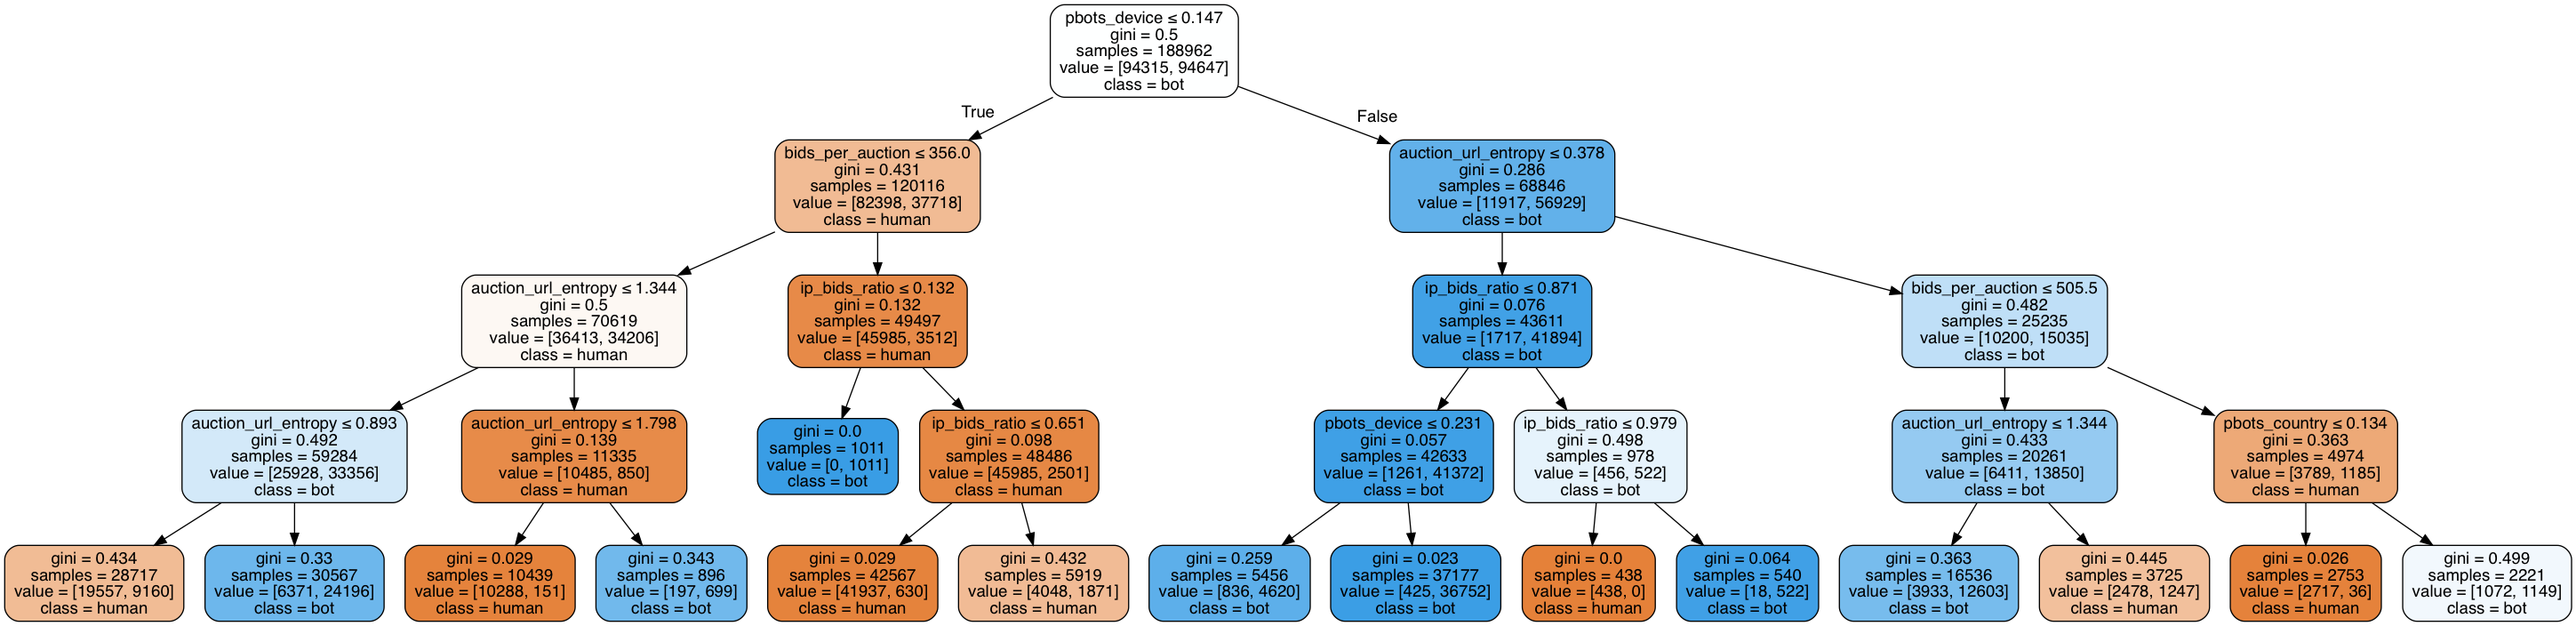

In [14]:
dot_data = StringIO()
export_graphviz(clf_dt, out_file=dot_data, 
                         filled=True, rounded=True,
                     feature_names=X.columns.values,
                     class_names = ['human','bot'],
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [15]:
# predict
y_dt_pred = clf_dt.predict(X_test)
y_dt_score = clf_dt.predict_proba(X_test)[:,1]

Evaluation Metric
----

In [16]:
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from pylab import rcParams

In [17]:
# accuracy score
print(f"Decision Tree Accuracy: {accuracy_score(y_dt_pred, y_test):.3f}")

Decision Tree Accuracy: 0.864


In [18]:
print('Classification Report of Model 1 Decision Tree')
print(classification_report(y_test, y_dt_pred))

Classification Report of Model 1 Decision Tree
             precision    recall  f1-score   support

          0       0.87      0.86      0.86     23769
          1       0.86      0.87      0.86     23472

avg / total       0.86      0.86      0.86     47241



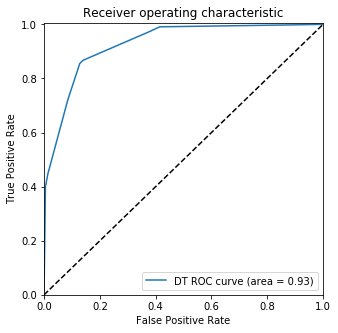

In [19]:
# Plot ROC in one graph
fpr_dt, tpr_dt, _dt = roc_curve(y_test, y_dt_score)
roc_dt_auc = auc(fpr_dt, tpr_dt)

plt.figure(figsize=(5,5))
plt.plot(fpr_dt, tpr_dt, label='DT ROC curve (area = %0.2f)' % roc_dt_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.005])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()